# Table of Contents
1. [Import Libraries](#1)
2. [Data preparation for tensorflow](#2)
3. [Tensorflow Implementation](#3)
4. [Data preparation for pytorch](#4)
5. [Pytorch Implementation](#5)

<a id="1"><a>
## Libraries
    

In [2]:
import nibabel as nib
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.feature_extraction import create_feature_extractor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import segmentation_models_pytorch as smp

In [3]:
torchvision.__version__

'0.15.2'

### Try with one image first

(240, 240, 155)


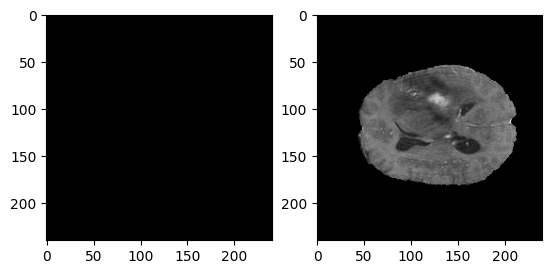

In [4]:
img = nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii')
img_array = img.get_fdata()
print(img_array.shape)
plt.subplot(121)
plt.imshow(img_array[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(img_array[:,:,80], cmap='gray')

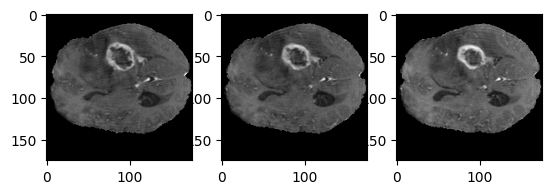

In [5]:
i = 72
plt.subplot(131)
plt.imshow(img_array[40:215, 40:215, i], cmap='gray')
plt.subplot(132)
plt.imshow(img_array[40:215, 40:215, i+1], cmap='gray')
plt.subplot(133)
plt.imshow(img_array[40:215, 40:215, i+2], cmap='gray')

In [7]:
x = img_array/np.max(img_array)
print(x.max())
print(type(x[0,0,0]))
x = x.astype(np.float32)
print(type(x[0,0,0]))

1.0
<class 'numpy.float64'>
<class 'numpy.float32'>


(240, 240, 155)
[0 1 2 4]


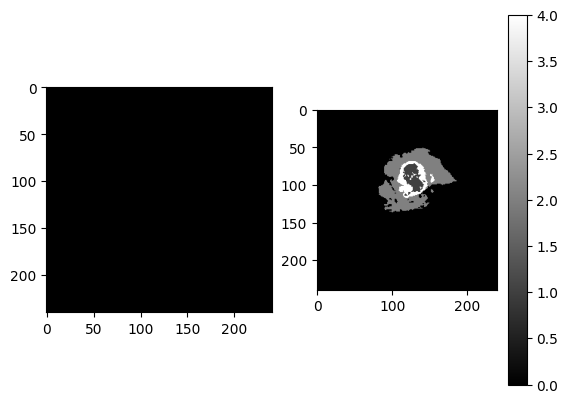

In [9]:
mask = nib.load('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii')
mask_array = mask.get_fdata().astype(np.uint8)
print(mask_array.shape)
print(np.unique(mask_array))
plt.subplot(121)
plt.imshow(mask_array[:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(mask_array[:,:,67], cmap='gray')
plt.colorbar()

In [10]:
print(np.unique(mask_array[:,:,0]))
print(np.unique(mask_array[:,:,67]))

[0]
[0 1 2 4]


In [11]:
mask_array[mask_array == 4] = 3
np.unique(mask_array)

array([0, 1, 2, 3], dtype=uint8)

In [12]:
black = []
good = []
for i in range(155):
    if np.unique(mask_array[:,:,i] == 0)[0] == True:
        black.append(i)
    else:
        good.append(i)
print(black)
print(good)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]


In [13]:
size = img_array[40:220, 40:220, 30:113].shape
size

(180, 180, 83)

In [14]:
mask_array[:,:,0].shape

(240, 240)

In [15]:
mask_array =  to_categorical(mask_array[:,:,0], num_classes=4)
mask_array = mask_array.astype(np.uint8)
mask_array.shape

(240, 240, 4)

In [16]:
mask_array[0,0]

array([1, 0, 0, 0], dtype=uint8)

In [19]:
train_images_paths = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
train_masks_paths = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
train_masks_paths.insert(354,'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii')
scaler = MinMaxScaler()
print(len(train_images_paths))
print(len(train_masks_paths))

369
369


In [20]:
x_train, x_test, y_train, y_test = train_test_split(train_images_paths, train_masks_paths, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(len(x_train))
print(len(x_val))
print(len(x_test))

298
34
37


<a id="2"><a>
## Data preparation for tensorflow

In [24]:
cc = load_mask(train_masks_paths[:10])
cc.shape

(830, 240, 240, 4)

In [22]:
def load_img(img_list):
    train_images= []
    for i, image_path in enumerate(img_list):    
#         print(i)
        image_t1ce= nib.load(image_path).get_fdata()
        image_t1ce = image_t1ce/np.max(image_t1ce)
#         image_t1ce= scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)
        image_t1ce = image_t1ce.astype(np.float32)
#         temp_combined_images = temp_image_t1ce[...,np.newaxis]
#         print(temp_combined_images.shape)
#         image_t1ce= image_t1ce[40:220, 40:220, 30:113]
        image_t1ce= image_t1ce[:, :, 30:113]
        for j in range(83):
            channel = image_t1ce[:,:,j]
            RGB_img = np.repeat(channel[...,np.newaxis], 3, axis=-1)
#             print("RGB: ", RGB_img.shape)
            train_images.append(RGB_img)
    
    train_images = np.array(train_images)
    return train_images

def load_mask( mask_list):
    train_masks = []
    for i, mask_path in enumerate(mask_list): 
        
        mask = nib.load(mask_path).get_fdata()
        mask[mask==4] = 3  #Reassign mask values 4 to 3
#         mask = mask[40:220, 40:220, 30:113]
        mask = mask[:, :, 30:113]
#         temp_mask= to_categorical(temp_mask, num_classes=4)
        for j in range(83):
            channel = mask[:,:,j]
            channel =  to_categorical(channel, num_classes=4)
            channel = channel.astype(np.float32)
            train_masks.append(channel)
#             train_masks.append(channel[...,np.newaxis])
    
    train_masks = np.array(train_masks)
    return train_masks



def imageLoader( img_list,  mask_list,batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_list[batch_start:limit])
#             X_new=np.moveaxis(X,-1,1)
#             X_new= X
            Y = load_mask( mask_list[batch_start:limit])
#             Y_new=np.moveaxis(Y,-1,1)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples    
#             yield (X_new,[ Y_new , X_new] ) #a tuple with two numpy arrays with batch_size samples     


            batch_start += batch_size   
            batch_end += batch_size

############################################

In [40]:
def imageLoader(img_list, mask_list, batch_size):
    L = len(img_list)
    steps = L // batch_size  # Total steps in one epoch
    
    while True:
        for step in range(steps):
            batch_start = step * batch_size
            batch_end = (step + 1) * batch_size
            limit = min(batch_end, L)

            X = load_img(img_list[batch_start:limit])
            Y = load_mask(mask_list[batch_start:limit])

            yield (X, Y)


In [25]:
np.unique(cc[0])

array([0., 1.], dtype=float32)

<a id="3"><a>
# Tensorflow

In [51]:
batch_size = 1
IMAGE_SIZE = 240
NUM_CLASSES = 4

In [52]:
train_datagen = imageLoader(x_train, y_train, batch_size)
val_datagen = imageLoader(x_test, y_test, batch_size)

In [53]:
def convolution_block(block_input,num_filters=128, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)
    print("Inside dspp, out_pool: ", out_pool.shape)
    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [54]:
resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_shape = (240,240,3))
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 246, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 120, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 120, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 60, 60, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 60, 60, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 60, 60, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 30, 30, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 30, 30, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 30, 30, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 15, 15, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 15, 15, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 15, 15, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 15, 15, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 15, 15, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 15, 15, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 15, 15, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 15, 15, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 15, 15, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 15, 15, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [55]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    resnet50.trainable = False
    x = resnet50.get_layer("conv4_block6_2_relu").output
    print("dspp in: ", x.shape)
    x = DilatedSpatialPyramidPooling(x)
    
    print("dspp out: ", x.shape)
    print(image_size // 4 // x.shape[1])
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=24, kernel_size=1)
    
    print("encoder out: ", input_a.shape)
    print("first out: ", input_b.shape)
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax',padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

In [56]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

dspp in:  (None, 15, 15, 256)
Inside dspp, out_pool:  (None, 15, 15, 128)
dspp out:  (None, 15, 15, 128)
4
encoder out:  (None, 60, 60, 128)
first out:  (None, 60, 60, 24)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 246, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 120, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNor

 conv2_block2_out (Activati  (None, 60, 60, 256)          0         ['conv2_block2_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 60, 60, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 60, 60, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 60, 60, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)   

                                                                                                  
 conv3_block2_2_relu (Activ  (None, 30, 30, 128)          0         ['conv3_block2_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 30, 30, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 30, 30, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_blo

 ation)                                                                                           
                                                                                                  
 conv4_block1_2_conv (Conv2  (None, 15, 15, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 15, 15, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 15, 15, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block3_add (Add)      (None, 15, 15, 1024)         0         ['conv4_block2_out[0][0]',    
                                                                     'conv4_block3_3_bn[0][0]']   
                                                                                                  
 conv4_block3_out (Activati  (None, 15, 15, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 15, 15, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 15, 15, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 average_pooling2d_1 (Avera  (None, 1, 1, 256)            0         ['conv4_block6_2_relu[0][0]'] 
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_10 (Conv2D)          (None, 1, 1, 128)            32896     ['average_pooling2d_1[0][0]'] 
                                                                                                  
 batch_normalization_9 (Bat  (None, 1, 1, 128)            512       ['conv2d_10[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 conv2d_11 (Conv2D)          (None, 15, 15, 128)          32768     ['conv4_block6_2_relu[0][0]'] 
          

 conv2d_18 (Conv2D)          (None, 60, 60, 128)          147456    ['tf.nn.relu_16[0][0]']       
                                                                                                  
 batch_normalization_17 (Ba  (None, 60, 60, 128)          512       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 tf.nn.relu_17 (TFOpLambda)  (None, 60, 60, 128)          0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 up_sampling2d_5 (UpSamplin  (None, 240, 240, 128)        0         ['tf.nn.relu_17[0][0]']       
 g2D)                                                                                             
          

In [65]:
checkpoint_filepath = 'checkpts'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    save_best_only = True
    )

In [58]:
epsilon = 1e-7
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / ( K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)
    return dice

In [59]:
def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    return 1 - dice

In [60]:
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=dice_coeff,
)

In [61]:
steps_per_epoch = len(x_train) // batch_size  # or however you calculate the training set size

In [67]:
validation_steps = len(x_val) // batch_size
history = model.fit(train_datagen, validation_data=val_datagen, epochs=25, steps_per_epoch=10, validation_steps=validation_steps,  verbose=1)

Epoch 1/25
10/10 [==============================] - 183s 19s/step - loss: 0.1214 - dice_coeff: 0.8786 - val_loss: 0.5777 - val_dice_coeff: 0.4223
Epoch 2/25
10/10 [==============================] - 179s 19s/step - loss: 0.0897 - dice_coeff: 0.9103 - val_loss: 0.4523 - val_dice_coeff: 0.5477
Epoch 3/25
10/10 [==============================] - 176s 19s/step - loss: 0.0630 - dice_coeff: 0.9370 - val_loss: 0.4287 - val_dice_coeff: 0.5713
Epoch 4/25
10/10 [==============================] - 180s 19s/step - loss: 0.0509 - dice_coeff: 0.9491 - val_loss: 0.3301 - val_dice_coeff: 0.6699
Epoch 5/25
10/10 [==============================] - 179s 19s/step - loss: 0.0451 - dice_coeff: 0.9549 - val_loss: 0.2566 - val_dice_coeff: 0.7434
Epoch 6/25
10/10 [==============================] - 178s 19s/step - loss: 0.0313 - dice_coeff: 0.9687 - val_loss: 0.1226 - val_dice_coeff: 0.8774
Epoch 7/25
10/10 [==============================] - 180s 19s/step - loss: 0.0262 - dice_coeff: 0.9738 - val_loss: 0.0299 - v

In [71]:
history.history['val_loss']

[0.5776704549789429,
 0.4523274898529053,
 0.42868316173553467,
 0.33009961247444153,
 0.25664106011390686,
 0.12263283133506775,
 0.029852205887436867,
 0.025494201108813286,
 0.024190228432416916,
 0.023886917158961296,
 0.023468904197216034,
 0.023518256843090057,
 0.02352008782327175,
 0.02398752234876156,
 0.023138931021094322,
 0.022971995174884796,
 0.02284213900566101,
 0.02357727847993374,
 0.023356137797236443,
 0.022679129615426064,
 0.021859943866729736,
 0.02113904058933258,
 0.022045563906431198,
 0.02265150286257267,
 0.023435302078723907]

In [72]:
history.history['val_dice_coeff']

[0.42232951521873474,
 0.5476725101470947,
 0.5713168382644653,
 0.6699004173278809,
 0.7433589696884155,
 0.8773671388626099,
 0.9701477289199829,
 0.9745058417320251,
 0.9758098721504211,
 0.9761130213737488,
 0.9765310883522034,
 0.9764817357063293,
 0.9764798283576965,
 0.9760124087333679,
 0.9768611788749695,
 0.9770278930664062,
 0.9771579504013062,
 0.9764226078987122,
 0.9766437411308289,
 0.9773209691047668,
 0.9781402349472046,
 0.9788608551025391,
 0.9779543876647949,
 0.9773484468460083,
 0.976564884185791]

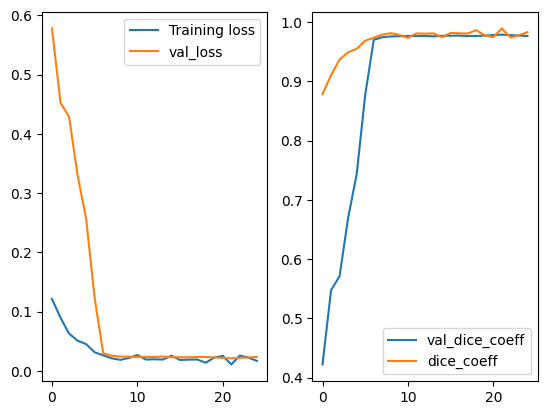

In [70]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training loss', 'val_loss'])

ax2.plot(history.history['val_dice_coeff'])
ax2.plot(history.history['dice_coeff'])
ax2.legend(['val_dice_coeff', 'dice_coeff'])